In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
import os

os.chdir("D:\COMPETITIONS\TianChen\Feature")



def tprweight_funtion(y_true, y_prob ):
    d = pd.DataFrame()
    d['prob'] = list(y_prob)
    d['y'] = list(y_true)
    print(d.head())
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3


def tpr_weight_funtion(preds, dtrain):
    labels = dtrain.get_label()
    tpr_score = tprweight_funtion(labels, preds)
    return [('gini', tpr_score)]

In [12]:
xgb

<module 'xgboost' from 'D:\\Programfiles2\\anaconda\\lib\\site-packages\\xgboost\\__init__.py'>

In [3]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [15]:
import xgboost as xgb

In [16]:
xgb.__version__

'0.81'

In [126]:
idTrain =  train_dfAderson["UID"]
idTest =  test_dfAderson["UID"]



train_dfAderson = train_dfAderson.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
test_dfAderson = test_dfAderson.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

train_dfAderson["UID"] = idTrain
test_dfAderson["UID"] = idTest

In [128]:
train_df = pd.merge(train_df, train_dfTrain_Mac_Wifi_Geo_Mode,how="left")
test_df = pd.merge(test_df, test_dfTrain_Mac_Wifi_Geo_Mode,how="left")
test_df = test_df.drop("tmpUID",axis=1)
train_df = pd.merge(train_df, trainAddr,how="left")
test_df = pd.merge(test_df, testAddr,how="left")
train_df = pd.merge(train_df, train_dfAderson,how="left")
test_df = pd.merge(test_df, test_dfAderson,how="left")




In [133]:
train_df.to_csv("train_df_latest.csv",encoding="utf8",index=False)
test_df.to_csv("test_df_latest.csv",encoding="utf8",index=False)

In [10]:
# (31179, 31198)
# train_df.Tag.unique()
# len(test_df.columns)
# len(test_df)
# train_df["User_maxOfAll_ip1"]

In [22]:
# # len(train_df.columns),len(test_df.columns)
b = list(train_df.columns)
a = list(test_df.columns)
print(list(set(b).difference(set(a))) )# b中有而a中没有的
print(list(set(a).difference(set(b))) )# a中有而

# print(len(list(set(b).intersection(set(a))))) # b中有而a中没有的


['Tag']
['tmpUID']


In [20]:
b = [1,2,3,5]
a = [1]
print(list(set(b).difference(set(a))) )# b中有而a中没有的
print(list(set(a).difference(set(b))) )# a中有而

[2, 3, 5]
[]


In [132]:
# trainAddr = pd.read_csv("trainAddrProV.csv",encoding="utf8")
# testAddr = pd.read_csv("testAddrProV.csv",encoding="utf8")
# train_dfTrain_Mac_Wifi_Geo_Mode = train_dfTrain_Mac_Wifi_Geo_Mode.drop("Tag",axis=1)
# trainAddr = trainAddr.drop("Tag",axis=1)
# train_df.UID.unique()
# train_dfTrain_Mac_Wifi_Geo_Mode = train_dfTrain_Mac_Wifi_Geo_Mode.drop("Tag",axis=1)
# train_dfTrain_Mac_Wifi_Geo_Mode.columns
# train_df
# train_dfTrain_Mac_Wifi_Geo_Mode
# trainAddr
# test_df.columns

In [2]:
# train_df = pd.read_csv("trainDummyMerchantCntonUID_V2.csv",encoding="utf8")

# test_df = pd.read_csv('testDummyMerchantCntonUID_V2.csv', na_values="-1",encoding="utf8")   

train_df = pd.read_csv("train_df_latest.csv",encoding="utf8")

test_df = pd.read_csv('test_df_latest.csv', na_values="-1",encoding="utf8")   
# train_dayFea =  pd.read_csv("train_routeFeature.csv",encoding="utf8")
# test_dayFea =  pd.read_csv("test_routeFeature.csv",encoding="utf8")

# train_df = pd.merge(train_df, train_dayFea,how="left")
# test_df = pd.merge(test_df, test_dayFea,how="left")
# train_df = frequencyOrder(train_df,"mostOperCntinRoutes")
# test_df =  frequencyOrder(test_df,"mostOperCntinRoutes")
# train_df = train_df.drop("mostOperCntinRoutes",axis=1)
# test_df = test_df.drop("mostOperCntinRoutes",axis=1)
# for col in ["FirOpperGroupCNT","MINrouteGroupCNT","MAXrouteGroupCNT","mostOperCntinRoutesGroupCNT"]:
#     train_df[col] = np.log(train_df[col] + 1)
#     test_df[col] = np.log(test_df[col]  + 1)

# train_geo_codeMac1Ip1 =  pd.read_csv("train_geo_codeMac1Ip1.csv",encoding="utf8")
# test_geo_codeMac1Ip1 =  pd.read_csv("test_geo_codeMac1Ip1.csv",encoding="utf8")
# train_geo_codeMac1Ip1 = train_geo_codeMac1Ip1.drop("Tag",axis=1)
# test_geo_codeMac1Ip1 = test_geo_codeMac1Ip1.drop("tmpUID",axis=1)
# train_df = pd.merge(train_df, train_geo_codeMac1Ip1,how="left")
# test_df = pd.merge(test_df, test_geo_codeMac1Ip1,how="left")
# test_df = test_df.drop("tmpUID",axis=1)
# train_basDaysBalSummaryOverDay =  pd.read_csv("train_basDaysBalSummaryOverDay.csv",encoding="utf8")
# test_basDaysBalSummaryOverDay =  pd.read_csv("test_basDaysBalSummaryOverDay.csv",encoding="utf8")
# train_df = pd.merge(train_df, train_basDaysBalSummaryOverDay,how="left")
# test_df = pd.merge(test_df, test_basDaysBalSummaryOverDay,how="left")




# UIDInGeoUserCntBoxIdx_3.0
# UIDInGeoUserCntBoxIdx_4.0
# UIDInGeoUserCntBoxIdx_5.0
# UIDInGeoUserCntBoxIdx_6.0
# UIDInGeoUserCntBoxIdx_7.0
# UIDInGeoUserCntBoxIdx_nan
# UIDInMacUserCntBoxIdx_4.0
# UIDInMacUserCntBoxIdx_6.0
# UIDInMacUserCntBoxIdx_7.0
# UIDInMacUserCntBoxIdx_nan
# train_dfAderson = pd.read_csv("train_TimeAnderson.csv",encoding="utf8")

# test_dfAderson = pd.read_csv('test_TimeAnderson.csv',encoding="utf8")   

# train_dfTrain_Mac_Wifi_Geo_Mode = pd.read_csv("Train_Mac_Wifi_Geo_Mode.csv",encoding="utf8")

# test_dfTrain_Mac_Wifi_Geo_Mode = pd.read_csv('Test_Mac_Wifi_Geo_Mode.csv', na_values="-1",encoding="utf8")   
    
# # predictors
train_features =  [x for x in train_df.columns if x not in ["UID","Tag"]]


# train_features =list(trainAddr.columns[1:])+ ["trans_amt_max","memp_mean","trans_amt_min","uni_mem_mean","memp_max","uni_device_mean","uni_mem_max","uni_device_min","uni_device_max","members_min","members_max","memp_min","merchant_x","uni_mem_min","trans_amt_mean","members_mean","max_time","time2","UIDInWifiUserCntBoxIdx_7.0","modeTypes_2.0","most_time","UID_VAL4amt_src1merchanthas_nan","UID_VAL2amt_src1merchanthas_nan","modeTypes_9.0","UID_VAL4trans_type1merchanthas_5.0","UID_VAL7amt_src1merchanthas_nan","time4","min_time","UIDInWifiUserCntBoxIdx_4.0","UID_VAL4amt_src1merchanthas_4.0","UID_VAL28amt_src1merchanthas_6.0","modeTypes_11.0","modeTypes_12.0","UIDInGeoUserCntBoxIdx_5.0","UIDInGeoUserCntBoxIdx_nan","modeTypes_3.0","UIDInMacUserCntBoxIdx_nan","time3","modeTypes_8.0","UID_VAL8amt_src1merchanthas_nan","modeTypes_1.0","UID_VAL10amt_src1merchanthas_nan","device2","mean_time","UID_VAL3trans_type1merchanthas_nan","amt_src1","UIDInWifiUserCntBoxIdx_5.0","modeTypes_6.0","UIDInGeoUserCntBoxIdx_4.0","UID_VAL5trans_type1merchanthas_3.0","UID_VAL3amt_src1merchanthas_5.0","UID_VAL3amt_src1merchanthas_nan","UID_VAL7amt_src1merchanthas_5.0","UIDInMacUserCntBoxIdx_4.0","UID_VAL2amt_src1merchanthas_7.0","UID_VAL3amt_src1merchanthas_7.0","UID_VAL7amt_src1merchanthas_4.0","UID_VAL2trans_type1merchanthas_7.0","UID_VAL2trans_type1merchanthas_4.0","UID_VAL7trans_type1merchanthas_4.0","UID_VAL3amt_src1merchanthas_6.0","UID_VAL4amt_src1merchanthas_7.0","UID_VAL6amt_src1merchanthas_nan","UID_VAL15amt_src1merchanthas_4.0","UIDInGeoUserCntBoxIdx_7.0","UIDInMacUserCntBoxIdx_7.0","UID_VAL1trans_type1merchanthas_nan","UID_VAL2amt_src1merchanthas_4.0","UID_VAL10amt_src1merchanthas_5.0","UID_VAL1trans_type1merchanthas_7.0","UID_VAL10amt_src1merchanthas_7.0","UID_VAL4trans_type1merchanthas_nan","UID_VAL2trans_type2merchanthas_7.0","UID_VAL4amt_src1merchanthas_5.0","UID_VAL2trans_type1merchanthas_6.0","UID_VAL1amt_src1merchanthas_nan","UID_VAL2amt_src1merchanthas_6.0","UID_VAL3amt_src1merchanthas_4.0","uni_trans_min","modeTypes_4.0","UIDInGeoUserCntBoxIdx_6.0","UID_VAL2trans_type2merchanthas_5.0","UID_VAL2trans_type2merchanthas_6.0","UID_VAL2amt_src1merchanthas_5.0","UID_VAL6amt_src1merchanthas_4.0","UID_VAL7amt_src1merchanthas_6.0","UID_VAL7amt_src1merchanthas_7.0","UID_VAL10amt_src1merchanthas_4.0","UID_VAL3trans_type1merchanthas_7.0","UID_VAL2trans_type2merchanthas_nan","UID_VAL5trans_type2merchanthas_nan","UID_VAL2trans_type1merchanthas_5.0","UID_VAL1trans_type2merchanthas_6.0","UID_VAL5trans_type2merchanthas_7.0","UID_VAL8amt_src1merchanthas_7.0","UID_VAL9amt_src1merchanthas_nan","time1","UIDInWifiUserCntBoxIdx_6.0","modeTypes_nan","UID_VAL10trans_type1merchanthas_4.0","UID_VAL1amt_src1merchanthas_7.0","UID_VAL9amt_src1merchanthas_7.0","uni_trans_mean","UIDInWifiUserCntBoxIdx_nan","UIDInMacUserCntBoxIdx_6.0","UID_VAL3trans_type1merchanthas_5.0","UID_VAL5trans_type1merchanthas_nan","UID_VAL2trans_type2merchanthas_4.0","uni_trans_max","modeTypes_5.0","UID_VAL2trans_type1merchanthas_nan","UID_VAL4trans_type1merchanthas_4.0","UID_VAL8trans_type1merchanthas_nan","UID_VAL10trans_type1merchanthas_nan","UID_VAL12trans_type1merchanthas_3.0","UID_VAL12trans_type1merchanthas_nan","UID_VAL13trans_type1merchanthas_nan","UID_VAL1trans_type2merchanthas_7.0","UID_VAL1trans_type2merchanthas_nan","UID_VAL3trans_type2merchanthas_4.0","UID_VAL3trans_type2merchanthas_7.0","UID_VAL3trans_type2merchanthas_nan","UID_VAL6amt_src1merchanthas_5.0","UID_VAL6amt_src1merchanthas_7.0","UID_VAL8amt_src1merchanthas_5.0","UID_VAL9amt_src1merchanthas_4.0","UID_VAL10amt_src1merchanthas_6.0","UID_VAL15amt_src1merchanthas_3.0","UID_VAL20amt_src1merchanthas_4.0","device1_null","time6"]
# trainB_features = list(train_dayFea.columns[1:]) + ["trans_amt_max","memp_mean","trans_amt_min","memp_max","uni_mem_mean","uni_device_mean","memp_min","uni_mem_max","members_max","uni_device_min","uni_device_max","uni_mem_min","merchant_x","trans_amt_mean","members_min","members_mean","time2","max_time","UIDInWifiUserCntBoxIdx_7.0","most_time","ProV_nan","modeTypes_2.0","UID_VAL4amt_src1merchanthas_nan","UID_VAL2amt_src1merchanthas_nan","UID_VAL4amt_src1merchanthas_4.0","UID_VAL7amt_src1merchanthas_nan","modeTypes_9.0","UID_VAL4trans_type1merchanthas_5.0","min_time","UIDInWifiUserCntBoxIdx_4.0","modeTypes_3.0","device2","modeTypes_1.0","mean_time","UIDInGeoUserCntBoxIdx_5.0","UID_VAL5trans_type1merchanthas_3.0","UID_VAL28amt_src1merchanthas_6.0","UIDInGeoUserCntBoxIdx_nan","ProV_unknow","time3","UID_VAL8amt_src1merchanthas_nan","modeTypes_8.0","time4","UIDInMacUserCntBoxIdx_nan","amt_src1","UID_VAL3amt_src1merchanthas_5.0","UID_VAL2trans_type1merchanthas_7.0","UID_VAL4amt_src1merchanthas_7.0","ProV_NeiMengGu","modeTypes_12.0","UID_VAL10amt_src1merchanthas_nan","UID_VAL6amt_src1merchanthas_nan","UID_VAL1trans_type1merchanthas_nan","UIDInWifiUserCntBoxIdx_5.0","modeTypes_6.0","UID_VAL3amt_src1merchanthas_nan","time1","UID_VAL3trans_type1merchanthas_nan","UIDInGeoUserCntBoxIdx_4.0","UID_VAL15amt_src1merchanthas_4.0","UIDInGeoUserCntBoxIdx_7.0","ProV_ShanXi","UID_VAL7amt_src1merchanthas_5.0","UID_VAL3amt_src1merchanthas_7.0","ProV_GuangDong","UIDInMacUserCntBoxIdx_4.0","UID_VAL2amt_src1merchanthas_7.0","UID_VAL4amt_src1merchanthas_5.0","UID_VAL2amt_src1merchanthas_6.0","ProV_HeBei","ProV_JiangXi","UID_VAL7trans_type1merchanthas_4.0","UID_VAL3amt_src1merchanthas_6.0","UIDInMacUserCntBoxIdx_7.0","UID_VAL10amt_src1merchanthas_4.0","ProV_JiangSu","UID_VAL7amt_src1merchanthas_4.0","ProV_SiChuan","UID_VAL2amt_src1merchanthas_4.0","ProV_AnHui","UID_VAL4trans_type1merchanthas_nan","UID_VAL2trans_type2merchanthas_7.0","UID_VAL2trans_type2merchanthas_6.0","uni_trans_mean","UID_VAL10amt_src1merchanthas_5.0","UID_VAL1trans_type1merchanthas_7.0","UID_VAL2trans_type1merchanthas_6.0","modeTypes_4.0","UID_VAL6amt_src1merchanthas_4.0","ProV_GuiZhou","UID_VAL2trans_type1merchanthas_4.0","UID_VAL2trans_type1merchanthas_5.0","UID_VAL5trans_type2merchanthas_7.0","UID_VAL10amt_src1merchanthas_7.0","UID_VAL7amt_src1merchanthas_6.0","UID_VAL5trans_type2merchanthas_nan","UID_VAL1trans_type2merchanthas_6.0","UID_VAL8amt_src1merchanthas_7.0","UID_VAL1amt_src1merchanthas_nan","UID_VAL3amt_src1merchanthas_4.0","uni_trans_min","UID_VAL2amt_src1merchanthas_5.0","UID_VAL7amt_src1merchanthas_7.0","UID_VAL2trans_type2merchanthas_nan","modeTypes_nan","uni_trans_max","UID_VAL2trans_type1merchanthas_nan","ProV_HuNan","ProV_ShanDong","UIDInGeoUserCntBoxIdx_6.0","UID_VAL2trans_type2merchanthas_5.0","UID_VAL3trans_type1merchanthas_7.0","UID_VAL9amt_src1merchanthas_nan","UID_VAL5trans_type1merchanthas_nan","modeTypes_5.0","UID_VAL3trans_type2merchanthas_7.0","UID_VAL3trans_type2merchanthas_nan","UID_VAL10amt_src1merchanthas_6.0","ProV_CHINAArea","ProV_GanSu","UIDInWifiUserCntBoxIdx_6.0","UID_VAL10trans_type1merchanthas_4.0","UIDInWifiUserCntBoxIdx_nan","UID_VAL4trans_type1merchanthas_4.0","UID_VAL1trans_type2merchanthas_7.0","ProV_LiaoNing","modeTypes_11.0","UID_VAL1amt_src1merchanthas_7.0","UID_VAL9amt_src1merchanthas_7.0","UIDInMacUserCntBoxIdx_6.0","UID_VAL1trans_type2merchanthas_nan","UID_VAL6amt_src1merchanthas_5.0","UID_VAL6amt_src1merchanthas_7.0","device1_null"]
# unImportant = ["user_dayCnt12","user_dayCnt13","user_dayCnt21","user_dayCnt27","UID_VAL2trans_type2merchanthas_nan","ProV_ShanDong","ProV_CHINAArea","UID_VAL9amt_src1merchanthas_7.0","UIDInMacUserCntBoxIdx_6.0","UID_VAL1trans_type2merchanthas_nan","UID_VAL6amt_src1merchanthas_7.0"]

# unImportant = ["UIDInGeoUserCntBoxIdx_3.0","UIDInGeoUserCntBoxIdx_4.0","UIDInGeoUserCntBoxIdx_5.0","UIDInGeoUserCntBoxIdx_6.0","UIDInGeoUserCntBoxIdx_7.0","UIDInGeoUserCntBoxIdx_nan","UIDInMacUserCntBoxIdx_4.0","UIDInMacUserCntBoxIdx_6.0","UIDInMacUserCntBoxIdx_7.0","UIDInMacUserCntBoxIdx_nan"]
# um10 = ["device1_null","device2_null","UIDInWifiUserCntBoxIdx_6.0","UIDInWifiUserCntBoxIdx_nan","modeTypes_7.0","modeTypes_10.0","ProV_AnHui","ProV_BeiJing","ProV_CHINAArea","ProV_ChongQing","ProV_FuJian","ProV_GuangXi","ProV_GuiZhou","ProV_HaiNan","ProV_HeBei","ProV_HeNan","ProV_HeiLongJiang","ProV_HuBei","ProV_HuNan","ProV_JiLin","ProV_LiaoNing","ProV_NingXia","ProV_QingHai","ProV_ShanDong","ProV_ShanXi","ProV_ShangHai","ProV_SiChuan","ProV_TaiWan","ProV_TianJin","ProV_XiZang","ProV_XinJiang","ProV_ZheJiang","ProV_nan","uni_channel_min","uni_channel_max","uni_channel_mean","uni_trans_max","time0","time1","time5","time6","user_dayCnt2","user_dayCnt3","user_dayCnt4","user_dayCnt5","user_dayCnt6","user_dayCnt7","user_dayCnt8","user_dayCnt11","user_dayCnt12","user_dayCnt13","user_dayCnt14","user_dayCnt16","user_dayCnt17","user_dayCnt20","user_dayCnt21","user_dayCnt24","user_dayCnt25","user_dayCnt27","user_dayCnt28","balUserbal_minOverDaysmean","balUserbal_minOverDaysmax","balUserbal_minOverDaysmin","balUserbal_maxOverDaysmean","balUserbal_maxOverDaysmax","balUserbal_meanOverDaysmean"]
# umall = unImportant + um10
# train_features = []
# for m in tmp_features:
#     if m not in umall:
#         train_features.append(m)

# # combs = [
# #     ('ps_reg_01', 'ps_car_02_cat'),  
# #     ('ps_reg_01', 'ps_car_04_cat'),
# # ]

# # lambda x: 
# for col in train_features:
#     test_df[col] = test_df[col].map(lambda x:0 if x ==0 else 1)
# for col in train_features:
#     train_df[col] = train_df[col].map(lambda x:0 if x ==0 else 1)
# # f = 
# # f(0)

In [42]:
# train_df = frequencyOrder(train_df,"mostOperCntinRoutes")
# test_df =  frequencyOrder(test_df,"mostOperCntinRoutes")
# train_df = train_df.drop("mostOperCntinRoutes",axis=1)
# test_df = test_df.drop("mostOperCntinRoutes",axis=1)
# for col in ["FirOpperGroupCNT","MINrouteGroupCNT","MAXrouteGroupCNT","mostOperCntinRoutesGroupCNT"]:
#     train_df[col] = np.log(train_df[col] + 1)
#     test_df[col] = np.log(test_df[col]  + 1)


# mostOperCntinRoutes drop
# FirOpperGroupCNT /MINrouteGroupCNT/MAXrouteGroupCNT/mostOperCntinRoutesGroupCNT/ log(x+1)

In [41]:
# test_df.mostOperCntinRoutes

#### save featuresFiles

In [58]:
# change log id = 5
# train_dfNew =   train_df[train_features+["UID","Tag" ]]
# test_dfNew = test_df[train_features+["UID" ]]
# os.rename("train_df_latest.csv","train_df_latestV5.csv")
# os.rename("test_df_latest.csv","test_df_latestV5.csv")
# train_dfNew.to_csv("train_df_latest.csv", encoding = "utf8",index = False)
# test_dfNew.to_csv("test_df_latest.csv", encoding = "utf8",index = False)
# del train_dfNew,test_dfNew

In [46]:
# train_dfNew
# len(train_df.columns),len(test_df.columns)

In [3]:
id_test = test_df['UID'].values
id_train = train_df['UID'].values
y = train_df['Tag']
# train_df.columns

In [5]:

# start = time.time()
# for n_c, (f1, f2) in enumerate(combs):
#     name1 = f1 + "_plus_" + f2
#     print('current feature %60s %4d in %5.1f'
#           % (name1, n_c + 1, (time.time() - start) / 60), end='')
#     print('\r' * 75, end='')
#     train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
#     test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
#     # Label Encode
#     lbl = LabelEncoder()
#     lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
#     train_df[name1] = lbl.transform(list(train_df[name1].values))
#     test_df[name1] = lbl.transform(list(test_df[name1].values))

#     train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

# f_cats = [f for f in X.columns if "_cat" in f]



In [6]:
y_valid_pred = 0*y
y_test_pred = 0

In [8]:

def frequencyOrder(df,variable):
    Countdf = df.groupby(variable).agg({ "UID":np.count_nonzero }).add_suffix('Cnt').reset_index()
    Countdf[variable+"Rank"] = Countdf["UIDCnt"].rank(ascending=0,method='dense')
    Countdf.columns = [variable,variable+ "GroupCNT",variable+"Rank" ]
    return pd.merge(df,Countdf, how="left")


In [63]:
# train_dayFea.head()
# test_dayFea


### 试试别人的调参代码

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
y = train_df["Tag"]
X = train_df[train_features]

# Create train and test set 
x_train,x_test,y_train,y_test = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)
# train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)
# print("Taille des predictor sur le train set : ", train_X.shape)
# print("Taille de la target sur le train set : ", train_y.shape)
# print("Taille des predictor sur le test set : ", test_X.shape)
# print("Taille de la target sur le test set : ", test_y.shape)

my_imputer = Imputer()
x_train = my_imputer.fit_transform(x_train)
x_test = my_imputer.transform(x_test)

D:\Programfiles2\anaconda\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score

from xgboost import XGBRegressor
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

"""
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
"""

# Performance sur le train
train_y_pred = my_model.predict(train_X)
auc = roc_auc_score(train_y, train_y_pred)
print("Performance sur le train : ", auc)

# Performance sur le test
test_y_pred = my_model.predict(test_X)
auc = roc_auc_score(test_y, test_y_pred)
print("Performance sur le test : ", auc)


Performance sur le train :  0.9719221214906406
Performance sur le test :  0.9673989074298157


In [54]:
tprweight_funtion(test_y, test_y_pred)

       prob  y
0  0.035304  0
1  0.087473  0
2  0.026162  0
3  0.120814  1
4  0.009345  0


0.7178538390379279

In [55]:
# Step 1 : Fix learning rate and number of estimators for tuning tree-based parameters
xgb1 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=50, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27)
# modelfit(xgb1, train, train_X)
xgb1.fit(train_X, train_y)

# Performance sur le train
auc = tprweight_funtion(train_y, xgb1.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(test_y, xgb1.predict(test_X))
print("Performance sur le test : ", auc)



   prob  y
0     1  1
1     1  1
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.5277777777777778
   prob  y
0     0  0
1     0  0
2     0  0
3     0  1
4     0  0
Performance sur le test :  0.404995374653099


In [56]:
# Performance sur le train
auc = tprweight_funtion(train_y, xgb1.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(test_y, xgb1.predict(test_X))
print("Performance sur le test : ", auc)

   prob  y
0     1  1
1     1  1
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.5277777777777778
   prob  y
0     0  0
1     0  0
2     0  0
3     0  1
4     0  0
Performance sur le test :  0.404995374653099


In [62]:
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)



In [57]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,20,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(train_X,train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [58]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.9761450068291383)

In [63]:
# gsearch1.feature_importances_
# min_child_weight = float(np.sum(label == 0)) / np.sum(label == 1)

In [64]:
# Fix new param with optimal parameter
# fpreproc=fpreproc
xgb2 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,fpreproc=fpreproc,seed=27,
    max_depth = 3,
    min_child_weight = 1
)
# modelfit(xgb1, train, train_X)
xgb2.fit(train_X, train_y)

# Performance sur le train
auc = roc_auc_score(train_y, xgb2.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(test_y, xgb2.predict(test_X))
print("Performance sur le test : ", auc)

Performance sur le train :  0.9306664489012124
Performance sur le test :  0.8980270835623961


In [65]:
auc = tprweight_funtion(train_y, xgb2.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(test_y, xgb2.predict(test_X))
print("Performance sur le test : ", auc)

   prob  y
0     1  1
1     1  1
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.5993445692883895
   prob  y
0     0  0
1     0  0
2     0  0
3     0  1
4     0  0
Performance sur le test :  0.41036077705827934


In [113]:
# tempModels = eval("[(0,4),(0,2),(0,9),(0,3)]")
# tempModels.sort(key=lambda x: int(x[1]))
# tempModels
import random
str(random.randint(1,100)) + ".txt"

'12.txt'

In [67]:
# Now lets tune gamma value using the parameters already tuned above.
param_test3 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight = 1,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch3.fit(train_X,train_y)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\ut

({'mean_fit_time': array([157.65483241, 164.17204833, 166.31916804, 160.82249088,
         147.32151566]),
  'mean_score_time': array([0.16231499, 0.13429403, 0.15430932, 0.14410257, 0.11988511]),
  'mean_test_score': array([0.97614501, 0.9761114 , 0.97626236, 0.97629653, 0.97608132]),
  'mean_train_score': array([0.99626998, 0.99630189, 0.99628598, 0.99630158, 0.99630657]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 4, 2, 1, 5]),
  'split0_test_score': array([0.97759575, 0.97762706, 0.97732015, 0.97734257, 0.97661704]),
  'split0_train_score': array([0.99616544, 0.99610693, 0.99611497, 0.99613453, 0.99613921]),
  'split1_test_score': array([0.97468938, 0.97473538, 0.97461207, 0.97505852, 0.97516868]),
  'split1_train_score

In [68]:
xgb2 = XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0.3,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,fpreproc=fpreproc,seed=27,
    max_depth = 3,
    min_child_weight = 1
)
# modelfit(xgb1, train, train_X)
xgb2.fit(train_X, train_y)

# Performance sur le train
auc = tprweight_funtion(train_y, xgb2.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(test_y, xgb2.predict(test_X))
print("Performance sur le test : ", auc)


   prob  y
0     1  1
1     1  1
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.5984706616729087
   prob  y
0     0  0
1     0  0
2     0  0
3     0  1
4     0  0
Performance sur le test :  0.37400555041628125


In [70]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 3,
                                                  min_child_weight =1,
                                                  gamma=0.3, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
#                         eval_metric=tpr_weight_funtion,
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch4.fit(train_X,train_y)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [71]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Programfiles2\anaconda\lib\site-packages\sklearn\ut

({'mean_fit_time': array([142.98824615, 145.80504198, 146.85878806, 140.47146568,
         163.01301975, 161.50363131, 154.81935678, 158.24423161,
         172.30924616, 168.5552134 , 168.35838881, 173.46303177,
         180.49587703, 177.32156148, 185.23489175, 182.88565192]),
  'mean_score_time': array([0.15370898, 0.15050688, 0.14090052, 0.15390868, 0.17332425,
         0.14461832, 0.16769414, 0.15911684, 0.14341197, 0.15707555,
         0.15424638, 0.14089999, 0.14871607, 0.15772662, 0.16928067,
         0.13371119]),
  'mean_test_score': array([0.97573961, 0.97578319, 0.97645079, 0.97638787, 0.97519943,
         0.97579305, 0.9762957 , 0.97641911, 0.97546086, 0.97581722,
         0.97629653, 0.97617393, 0.97528851, 0.97561095, 0.97598504,
         0.9763362 ]),
  'mean_train_score': array([0.99588479, 0.99592735, 0.99599865, 0.99577995, 0.99604384,
         0.99612969, 0.99614684, 0.99589864, 0.99617534, 0.99628537,
         0.99630158, 0.99601947, 0.99632246, 0.99636558, 0.996366

In [ ]:
 {'colsample_bytree': 0.6, 'subsample': 0.8},

In [74]:
xgb5 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.6,
    max_depth = 3,
    min_child_weight = 1,
    objective= 'binary:logistic', nthread=4,fpreproc=fpreproc,seed=27
)
# modelfit(xgb1, train, train_X)
xgb5.fit(train_X, train_y)

# Performance sur le train
auc = tprweight_funtion(train_y, xgb5.predict(train_X))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(test_y, xgb5.predict(test_X))
print("Performance sur le test : ", auc)

   prob  y
0     1  1
1     1  1
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.5950686641697878
   prob  y
0     0  0
1     0  0
2     0  0
3     0  1
4     0  0
Performance sur le test :  0.3726179463459759


#### 非平衡样本评分函数

In [69]:
def aupr(y_true,y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true,y_pred)
    roc_aupr = auc(recall,precision) 
    return roc_aupr
from sklearn.metrics import fbeta_score, make_scorer
# score = make_scorer(my_custom_loss_func, greater_is_better=False)


In [76]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.metrics import confusion_matrix,make_scorer
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
import os

seed = 1231
np.random.seed(seed)
x_train,y_train,x_test,y_test = x_train,y_train,x_test,y_test
 
names = [ 'xgb']
classifiers = [XGBClassifier()]
 

parameter = {'n_estimators':range(400,1000,100),'learning_rate': [i/100 for i in range(1,21)]}
 
parameters = [parameter]
# ,"tprweight_funtion":make_scorer(tprweight_funtion, greater_is_better=True)
scoring = {'roc_auc':'roc_auc','accuracy':'accuracy', 'precision':'precision','recall':'recall','f1':'f1'}

def gird_search_model(clf,param,name,x_train,y_train,x_test,y_test): #clf-classifier;param-parameter;name-classifier_name
    model = GridSearchCV(clf,param,cv=5,verbose=2,scoring=scoring,refit='roc_auc',n_jobs=4,return_train_score=True) #GridSearchCV模型
    fit = model.fit(x_train,y_train) #GridSearchCV模型拟合训练集数据，并返回训练器集合为fit
    y_train_pred = fit.best_estimator_.predict(x_train) #用训练器集合中最好的estimator预测y_train_pred
    y_test_pred = fit.best_estimator_.predict(x_test) #用训练器集合中最好的estimator预测y_test_pred
    
    cv_results = pd.DataFrame(fit.cv_results_).set_index(['params']) #将训练器集合fit的cv_results保存为df格式
    cv_results_mean = cv_results[['mean_train_accuracy','mean_train_f1','mean_train_precision', 'mean_train_recall', 'mean_train_roc_auc',
                                  'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall','mean_test_roc_auc']] #cv_results中的各个score的mean
    cv_results_std = cv_results[['std_train_accuracy', 'std_train_f1', 'std_train_precision','std_train_recall', 'std_train_roc_auc',
                                 'std_test_accuracy', 'std_test_f1','std_test_precision', 'std_test_recall', 'std_test_roc_auc']] #cv_results中的各个score的std
 
#  -------------------模型结果展示------------------------------------------------------  
  
    print('MODEL : %r' % name)
    print('Best cv_test_roc_auc: %f using %s' % (fit.best_score_,fit.best_params_)) #训练器集合fit中最好的模型得到的：best_score和best_params
    print(cv_results_mean)
    print(cv_results_std)
    
    train_score_list = []
    test_score_list = []
    score_list = []
    model_metrics_name = [accuracy_score,tprweight_funtion,precision_score,recall_score,f1_score,roc_auc_score,aupr] #模型评价指标，与scoreing相对应
    for matrix in model_metrics_name: #计算各个模型评价指标
        train_score = matrix(y_train,y_train_pred) #计算训练集的
        test_score = matrix(y_test,y_test_pred) #计算测试集的
        train_score_list.append(train_score) #把训练集的各个模型指标放在同一行
        test_score_list.append(test_score) #把测试集的各个模型指标放在同一行
    score_list.append(train_score_list) #合并训练集和测试集的结果（便于展示）
    score_list.append(test_score_list) #合并训练集和测试集的结果（便于展示）
    score_df = pd.DataFrame(score_list,index = ['train','test'],columns = ['accuracy','tprweight_funtion','precision','recall','f1','roc_auc','aupr']) #将结果显示为df格式，加上行列index
    print('EVALUATE_METRICS:')
    print(score_df)   
    return cv_results,score_list,y_train_pred,y_test_pred

train_score_list = []
test_score_list = []
y_train_pred_list = []
y_test_pred_list = []
# parallel = Parallel(n_jobs=self.n_jobs, backend="multiprocessing",
#                             verbose=self.verbose, pre_dispatch=self.pre_dispatch)
for clf,param,name in zip(classifiers,parameters,names):
    cv_result,score_list,y_train_pred,y_test_pred =  gird_search_model(clf,param,name,x_train,y_train,x_test,y_test) #执行主模型函数
    train_score_list.append(score_list[0])
    test_score_list.append(score_list[1])
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    print('-------------------------------------------------------------------------------------------------------------------------------')
train_score_df = pd.DataFrame(train_score_list,index=names,columns=['acc','f1','pre','rec','roc_auc','aupr'])
test_score_df = pd.DataFrame(test_score_list,index=names,columns=['acc','pre','rec','f1','roc_auc','aupr'])
print('TRAIN_SCORE:')
print(train_score_df)
print()
print('TEST_SCORE:')
print(test_score_df)

# 'n_estimators': [400, 500, 600, 700, 800]
#     'max_depth':range(3,10,2),  
#     'min_child_weight':range(1,6,2)
# 'min_child_weight': [6, 8, 10, 12]  
# 'gamma': [i / 10.0 for i in range(0, 5)]  
#     'subsample': [i / 10.0 for i in range(6, 10)],  
#     'colsample_bytree': [i / 10.0 for i in range(6, 10)]  

# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]  
# fir
# 'reg_alpha': [0, 0.001, 0.005, 0.01,0.03, 0.05] 
# sec
# 'reg_alpha': [0, 0.001,0.003,0.01,0.03, 0.05, 0.1,0.3 ]
# 'reg_alpha': [0, 0.001, 0.005, 0.01,0.03, 0.05]  
# 0.03
# 'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100] 
# 'reg_lambda': [0, 0.1, 0.3, 1,3,10,30] 
# 这个先不调
# Step 6: Reducing Learning Rate in order to reduce overfit
# param_test6 = {
# 'reg_alpha': [0, 0.001,0.003,0.01,0.03, 0.05, 0.1,0.3 ]
# }
# gsearch6 =GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=700, 
#                                                   max_depth = 3,
#                                                   min_child_weight =1,
#                                                   gamma=0.3, 
#                                                  reg_alpha = 0.03,
#                                                   subsample=0.8, colsample_bytree=0.6,
#                                                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#                         param_grid = param_test6, 
#                         scoring='roc_auc',
# #                         eval_metric=tpr_weight_funtion,
#                         n_jobs=4,
#                         iid=False, 
#                         cv=5)
'learning_rate': 0.15, 'n_estimators': 400
mean_train_accuracy mean_train_f1 mean_train_precision mean_train_recall mean_train_roc_auc
mean_test_accuracy mean_test_f1 mean_test_precision mean_test_recall mean_test_roc_auc std_train_accuracy
std_train_f1 std_train_precision std_train_recall std_train_roc_auc std_test_accuracy std_test_f1 std_test_precision
std_test_recall std_test_roc_auc
# gsearch6.fit(train_X,train_y)
# gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 25.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 121.8min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 280.7min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed: 471.2min finished


MODEL : 'xgb'
Best cv_test_roc_auc: 0.979800 using {'learning_rate': 0.15, 'n_estimators': 400}
                                              mean_train_accuracy  \
params                                                              
{'learning_rate': 0.01, 'n_estimators': 400}             0.955771   
{'learning_rate': 0.01, 'n_estimators': 500}             0.959385   
{'learning_rate': 0.01, 'n_estimators': 600}             0.960582   
{'learning_rate': 0.01, 'n_estimators': 700}             0.961555   
{'learning_rate': 0.01, 'n_estimators': 800}             0.962335   
{'learning_rate': 0.01, 'n_estimators': 900}             0.963073   
{'learning_rate': 0.02, 'n_estimators': 400}             0.962282   
{'learning_rate': 0.02, 'n_estimators': 500}             0.963554   
{'learning_rate': 0.02, 'n_estimators': 600}             0.964698   
{'learning_rate': 0.02, 'n_estimators': 700}             0.965628   
{'learning_rate': 0.02, 'n_estimators': 800}             0.966537   
{'learn

AssertionError: 8 columns passed, passed data had 7 columns

In [97]:
# from hyperopt import fmin, tpe, hp, rand
# # import numpy as np
# # from sklearn.metrics import accuracy_score
# # from sklearn import svm
# # from sklearn import datasets

# # # SVM的三个超参数：C为惩罚因子，kernel为核函数类型，gamma为核函数的额外参数（对于不同类型的核函数有不同的含义）
# # # 有别于传统的网格搜索（GridSearch），这里只需要给出最优参数的概率分布即可，而不需要按照步长把具体的值给一个个枚举出来

# # x_train
# # y_train
# # x_test
# # y_test
   

# parameter_space_svc ={
#                         "n_estimators":400,
#                          'max_depth':hp.choice('max_depth', [3,5,7,9]),  
#                         "objective":"binary:logistic",
#                         "learning_rate":0.15, 
#                         "subsample":0.8,
#                         "max_delta_step" :1,
#                         "min_child_weight":hp.choice('min_child_weight', [1,3,5,7]),
#                         "colsample_bytree":0.6,
# #                         scale_pos_weight=scale_pos_weight,
#                         "fpreproc":fpreproc,
#                         "gamma":0.3,
#       "reg_alpha" : 0.03,
#     "reg_lambda":1
# }

# # # 鸢尾花卉数据集，是一类多重变量分析的数据集
# # # 通过花萼长度，花萼宽度，花瓣长度，花瓣宽度4个属性预测鸢尾花卉属于（Setosa，Versicolour，Virginica）三个种类中的哪一类
# # iris = datasets.load_digits()

# # #--------------------划分训练集和测试集--------------------
# # train_data = iris.data[0:1300]
# # train_target = iris.target[0:1300]
# # test_data = iris.data[1300:-1]
# # test_target = iris.target[1300:-1]
# # #-----------------------------------------------------------

# # # 计数器，每一次参数组合的枚举都会使它加1
# count = 0

# def function(args):
#     print(args)

#     # **可以把dict转换为关键字参数，可以大大简化复杂的函数调用
#     clf = XGBClassifier(**args)

#     # 训练模型
#     clf.fit(x_train,y_train)

#     # 预测测试集
#     prediction = clf.predict(x_test)

#     global count
#     count = count + 1
#     score = tprweight_funtion(y_test,prediction)
#     print("第%s次，测试集正确率为：" % str(count),score)

#     # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
#     return score

# # # algo指定搜索算法，目前支持以下算法：
# # # ①随机搜索(hyperopt.rand.suggest)
# # # ②模拟退火(hyperopt.anneal.suggest)
# # # ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# # # max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
# best = fmin(function, parameter_space_svc, algo=tpe.suggest, max_evals=30)

# # best["kernel"]返回的是数组下标，因此需要把它还原回来
# # kernel_list = ['rbf','poly']
# # best["kernel"] = kernel_list[best["kernel"]]

# print("最佳参数为：",best)

# # clf = svm.SVC(**best)
# # print(clf)


In [ ]:
parameter_space_svc ={
                        "n_estimators":400,
                         'max_depth':,  
                        "objective":"binary:logistic",
                        "learning_rate":0.15, 
                        "subsample":0.8,
                        "max_delta_step" :1,
                        "min_child_weight":,
                        "colsample_bytree":0.6,
#                         scale_pos_weight=scale_pos_weight,
                        "fpreproc":fpreproc,
                        "gamma":hp.choice('max_depth', [i / 10.0 for i in range(0, 7)]),  
      "reg_alpha" : 0.03,
    "reg_lambda":1
}

best = fmin(function, parameter_space_svc, algo=tpe.suggest, max_evals=30)

In [81]:
for clf_name,y_train_pred,y_test_pred in zip(names,y_train_pred_list,y_test_pred_list):
    show_curve(y_train,y_train_pred,clf_name,True)
    show_curve(y_test,y_test_pred,clf_name,False)


In [42]:

import matplotlib.pyplot as plt
def show_roc(roc_auc,fpr,tpr):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

def show_roc_pr(roc_aupr,recall,precision):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--',label='ROC curve (area = %0.2f)' % roc_aupr)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('ROC_PR curve')
    plt.legend(loc='best')
    plt.show()
    print()
def show_curve(y_true,y_pred,clf_name,train=True):
    fpr, tpr, thresholds1 = roc_curve(y_true,y_pred)
    precision, recall, thresholds2 = precision_recall_curve(y_true,y_pred)
    roc_auc = auc(fpr, tpr)
    roc_aupr = auc(recall,precision) 
    if train == True:
        print('%s  (%s)' %(clf_name,"train"))


In [88]:
#  0.47710951526032314
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)
# reg_alpha = 0.01

# reg_alpha = 0.01
# 0.69 0.46615
# 'reg_alpha': [0, 0.001, 0.005, 0.01,0.03, 0.05] 
#  0.701  0.4947
# 0.70 0.49

xgb5 = XGBClassifier(
    learning_rate =0.15, 
    n_estimators=400,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.6,
    max_depth = 3,
    reg_alpha = 0.03,
    reg_lambda=1,
    min_child_weight = 1,
    objective= 'binary:logistic', nthread=4,fpreproc=fpreproc,seed=27
)
# modelfit(xgb1, train, train_X)
xgb5.fit(x_train, y_train)
# x_train
# y_train
# x_test
# y_test
# Performance sur le train
auc = tprweight_funtion(y_train, xgb5.predict(x_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = tprweight_funtion(y_test, xgb5.predict(x_test))
print("Performance sur le test : ", auc)

   prob  y
0     0  0
1     0  0
2     0  0
3     0  0
4     0  0
Performance sur le train :  0.6857943925233645
   prob  y
0     0  0
1     0  0
2     0  0
3     0  0
4     0  0
Performance sur le test :  0.5146046511627906


### 调参2

In [68]:
# gsearch1.cv_results_

In [ ]:
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(30)

In [100]:
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE =0.15
EARLY_STOPPING_ROUNDS = 50  
# scale_pos_weight = float(np.sum(train_features["Tag"] == 0)) / np.sum(train_features["Tag"] == 1)

# parameter_space_svc ={
#                         "n_estimators":400,
#                          'max_depth':hp.choice('max_depth', [3,5,7,9]),  
#                         "objective":"binary:logistic",
#                         "learning_rate":0.15, 
#                         "subsample":0.8,
#                         "max_delta_step" :1,
#                         "min_child_weight":hp.choice('min_child_weight', [1,3,5,7]),
#                         "colsample_bytree":0.6,
# #                         scale_pos_weight=scale_pos_weight,
#                         "fpreproc":fpreproc,
#                         "gamma":0.3,
#       "reg_alpha" : 0.03,
#     "reg_lambda":1
# }
'max_depth', [3,5,7,9]
'min_child_weight', [1,3,5,7]
import itertools
# gamma":hp.choice('gamma', [i / 10.0 for i in range(0, 7)])

max_depths = [3,5,7,9]
min_child_weights = [1,3,5,7]
paraCo = list(itertools.product(max_depths,min_child_weights))

#  learning_rate =
#     n_estimators=,
#     gamma=,
#     subsample=,
#     colsample_bytree=0.8,
#     max_depth = 5,
#     min_child_weight = 5,
#     objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27

In [101]:
import itertools

parameters = {'nthread' : [-1],
              'objective':['binary:logistic'],
              'learning_rate': [0.1], #so called `eta` value
              "subsample":[1] ,
              'max_depth':[3], #[6,14],
              "min_child_weight":[1],
              'min_child_weight': [1], # [1,7,13],
              "colsample_bytree":[1],
              'silent': [1],
              "gamma":[0] ,
              "reg_alpha" :[0],
              "reg_lambda":[1],
              'n_estimators': [400,500,600,700], #number of trees, change it to 1000 for better results
              'seed': [1337]}
product = [x for x in itertools.product(*list(parameters.values())) ]
g = [dict((zip(parameters.keys(), p))) for p in product]

In [103]:
# [dict(zip(parameters.keys(), p)) for p in product]
for m in g:
    print(m)

{'max_depth': 3, 'subsample': 1, 'seed': 1337, 'silent': 1, 'colsample_bytree': 1, 'min_child_weight': 1, 'nthread': -1, 'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0, 'n_estimators': 400, 'reg_lambda': 1, 'objective': 'binary:logistic'}
{'max_depth': 3, 'subsample': 1, 'seed': 1337, 'silent': 1, 'colsample_bytree': 1, 'min_child_weight': 1, 'nthread': -1, 'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0, 'n_estimators': 500, 'reg_lambda': 1, 'objective': 'binary:logistic'}
{'max_depth': 3, 'subsample': 1, 'seed': 1337, 'silent': 1, 'colsample_bytree': 1, 'min_child_weight': 1, 'nthread': -1, 'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0, 'n_estimators': 600, 'reg_lambda': 1, 'objective': 'binary:logistic'}
{'max_depth': 3, 'subsample': 1, 'seed': 1337, 'silent': 1, 'colsample_bytree': 1, 'min_child_weight': 1, 'nthread': -1, 'gamma': 0, 'learning_rate': 0.1, 'reg_alpha': 0, 'n_estimators': 700, 'reg_lambda': 1, 'objective': 'binary:logistic'}


In [89]:
parameters.values()

dict_values([[1], [1337], [1], [1], [1], [-1], [0], [0.1], [0], ['binary:logistic'], [400, 500, 600, 700], [1], [3]])

In [102]:
paraScores = []
for max_depth,min_child_weight in paraCo:
    model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=max_depth,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=0.8,
                        max_delta_step = 1,
                        min_child_weight=min_child_weight,
                        colsample_bytree=0.6,
#                         scale_pos_weight=scale_pos_weight,
                        fpreproc=fpreproc,
                        gamma=0.3,
      reg_alpha = 0.03,
    reg_lambda=1
                     )
    for i, (train_index, test_index) in enumerate(kf.split(train_df)):

        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        X_test = test_df.copy()
        print( "\nFold ", i)
    #     if i >1:
    #         break

        # Enocode data
    #     for f in f_cats:
    #         X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
    #                                                         trn_series=X_train[f],
    #                                                         val_series=X_valid[f],
    #                                                         tst_series=X_test[f],
    #                                                         target=y_train,
    #                                                         min_samples_leaf=200,
    #                                                         smoothing=10,
    #                                                         noise_level=0
    #                                                         )
        # Run model for this fold
        if OPTIMIZE_ROUNDS:
            eval_set=[(X_valid,y_valid)]
            fit_model = model.fit( X_train, y_train, 
                                   eval_set=eval_set,
                                   eval_metric=tpr_weight_funtion,
                                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                   verbose=False
                                 )
            print( "  Best N trees = ", model.best_ntree_limit )
            print( "  Best gini = ", model.best_score )
        else:
            fit_model = model.fit( X_train, y_train )

        # Generate validation predictions for this fold
        pred = fit_model.predict_proba(X_valid)[:,1]
        print( "  Gini = ", tprweight_funtion(y_valid, pred) )
        y_valid_pred.iloc[test_index] = pred

        # Accumulate test set predictions
        y_test_pred += fit_model.predict_proba(X_test)[:,1]

        del X_test, X_train, X_valid, y_train

    y_test_pred /= K  # Average test set predictions

    print( "\nGini for full training set:" )
    tpr = tprweight_funtion(y, y_valid_pred)
    paraScores.append([max_depth,min_child_weight,tpr])
    print("para:max_depth:%s, min_child_weight:%s, score:%s"%( str(max_depth),str(min_child_weight),str(tpr)  ))
    
    


Fold  0
       prob  y
0  0.004462  0
1  0.006660  0
2  0.000014  0
3  0.013395  0
4  0.000098  0
  Gini =  0.7853113983548766

Fold  1
       prob  y
0  0.583174  1
1  0.003746  0
2  0.000086  0
3  0.000015  0
4  0.000359  0
  Gini =  0.7824009324009324

Fold  2
       prob  y
0  0.000113  0
1  0.000047  0
2  0.000131  0
3  0.000512  0
4  0.035099  0
  Gini =  0.7850402761795168

Fold  3
       prob  y
0  0.000498  0
1  0.000049  0
2  0.007041  0
3  0.998215  1
4  0.000012  0
  Gini =  0.7625145518044237

Fold  4
       prob  y
0  0.000367  0
1  0.000028  0
2  0.000141  0
3  0.000056  0
4  0.000128  0
  Gini =  0.7982311320754718

Gini for full training set:
       prob  y
0  0.583174  1
1  0.000498  0
2  0.004462  0
3  0.003746  0
4  0.000086  0
para:max_depth:3, min_child_weight:1, score:0.7834539089848308

Fold  0
       prob  y
0  0.004925  0
1  0.007772  0
2  0.000019  0
3  0.019425  0
4  0.000125  0
  Gini =  0.7901292596944771

Fold  1
       prob  y
0  0.693775  1
1  0.000843

In [104]:
# sorted(paraScores, key = lambda x: x[2])

[[3, 1, 0.7834539089848308],
 [3, 3, 0.7844574095682614],
 [3, 5, 0.7849474912485414],
 [3, 7, 0.7853908984830805],
 [5, 7, 0.791901983663944],
 [9, 7, 0.7921120186697783],
 [5, 3, 0.7931855309218203],
 [9, 5, 0.7942357059509918],
 [5, 5, 0.7944224037339556],
 [7, 7, 0.7946091015169195],
 [5, 1, 0.7949124854142358],
 [7, 5, 0.7950291715285881],
 [9, 1, 0.7964760793465577],
 [7, 3, 0.7966161026837806],
 [9, 3, 0.7966861143523921],
 [7, 1, 0.7968028004667445]]

#### 训练模型

In [9]:
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(30)

In [10]:
len(train_df.columns)

383

In [11]:

MAX_ROUNDS = 700
OPTIMIZE_ROUNDS = False
LEARNING_RATE =0.03
EARLY_STOPPING_ROUNDS = 50  
# scale_pos_weight = float(np.sum(train_features["Tag"] == 0)) / np.sum(train_features["Tag"] == 1)
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=13,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=0.7,
                        max_delta_step = 1,
                        min_child_weight=1,
                        colsample_bytree=0.9,
#                         scale_pos_weight=scale_pos_weight,
                        fpreproc=fpreproc,
                        gamma=7,
      reg_alpha =0.03,
    reg_lambda=0
                     )


#  learning_rate =
#     n_estimators=,
#     gamma=,
#     subsample=,
#     colsample_bytree=0.8,
#     max_depth = 5,
#     min_child_weight = 5,
#     objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=27

In [12]:
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
#     if i >1:
#         break
    
    # Enocode data
#     for f in f_cats:
#         X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
#                                                         trn_series=X_train[f],
#                                                         val_series=X_valid[f],
#                                                         tst_series=X_test[f],
#                                                         target=y_train,
#                                                         min_samples_leaf=200,
#                                                         smoothing=10,
#                                                         noise_level=0
#                                                         )
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=tpr_weight_funtion,
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=False
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", tprweight_funtion(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
tprweight_funtion(y, y_valid_pred)


Fold  0
       prob  y
0  0.010323  0
1  0.002240  0
2  0.000342  0
3  0.003573  0
4  0.000515  0
  Gini =  0.8074030552291422

Fold  1
       prob  y
0  0.394365  1
1  0.001219  0
2  0.000844  0
3  0.000371  0
4  0.002217  0
  Gini =  0.774009324009324

Fold  2
       prob  y
0  0.000763  0
1  0.000379  0
2  0.001041  0
3  0.002176  0
4  0.004957  0
  Gini =  0.7891829689298044

Fold  3
       prob  y
0  0.001339  0
1  0.000417  0
2  0.006402  0
3  0.998318  1
4  0.000288  0
  Gini =  0.7810244470314318

Fold  4
       prob  y
0  0.002047  0
1  0.000824  0
2  0.001355  0
3  0.000251  0
4  0.000571  0
  Gini =  0.8068396226415095

Gini for full training set:
       prob  y
0  0.394365  1
1  0.001339  0
2  0.010323  0
3  0.001219  0
4  0.000844  0


0.7958226371061843

In [130]:
val = pd.DataFrame()
val['UID'] = id_train
val['Tag'] = y_valid_pred.values
val.to_csv('xgb_validBeatBaseV13.csv', float_format='%.6f', index=False)

In [13]:
sub = pd.DataFrame()
sub['UID'] = id_test
sub['Tag'] = y_test_pred
sub.to_csv('xgb_submitBeatBaseV23.csv', float_format='%.6f', index=False)
# xgb_submitBeatBaseV13 去掉部分无用特征后

In [14]:
for fn,f in zip(train_features,model.feature_importances_):
    print(fn +  ":" +str(f))


UID_VAL1trans_type1merchanthas_4.0:0.0
UID_VAL1trans_type1merchanthas_5.0:0.0
UID_VAL1trans_type1merchanthas_6.0:0.0
UID_VAL1trans_type1merchanthas_7.0:0.0030677614
UID_VAL1trans_type1merchanthas_nan:0.003879816
UID_VAL2trans_type1merchanthas_4.0:0.00054136966
UID_VAL2trans_type1merchanthas_5.0:0.00018045655
UID_VAL2trans_type1merchanthas_6.0:0.001624109
UID_VAL2trans_type1merchanthas_7.0:0.0008120545
UID_VAL2trans_type1merchanthas_nan:0.0017143373
UID_VAL3trans_type1merchanthas_4.0:0.00018045655
UID_VAL3trans_type1merchanthas_5.0:0.0
UID_VAL3trans_type1merchanthas_6.0:0.0
UID_VAL3trans_type1merchanthas_7.0:9.022828e-05
UID_VAL3trans_type1merchanthas_nan:0.0018947938
UID_VAL4trans_type1merchanthas_3.0:0.0
UID_VAL4trans_type1merchanthas_4.0:0.0063159796
UID_VAL4trans_type1merchanthas_5.0:0.008301002
UID_VAL4trans_type1merchanthas_6.0:0.0
UID_VAL4trans_type1merchanthas_nan:0.00027068483
UID_VAL5trans_type1merchanthas_3.0:0.008391229
UID_VAL5trans_type1merchanthas_4.0:0.0
UID_VAL5trans_ty

In [82]:
# max_depths = [3,5,7,9]
# min_child_weights = [1,3,5,7]    
from itertools import product
# l = [1, 2, 3]
# subsample = [i / 10.0 for i in range(6, 10)]
# colsample_bytree = [i / 10.0 for i in range(6, 10)]  


  
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]
# max_depth = range(3,10,2)
# min_child_weight = range(1,6,2)

print(list(product(subsample,colsample_bytree    )))
print()
print(len(list(product(subsample,colsample_bytree    ))))
# parameter = {'n_estimators':range(400,1000,100),'learning_rate': ]}

[(0.6, 0.6), (0.6, 0.7), (0.6, 0.8), (0.6, 0.9), (0.7, 0.6), (0.7, 0.7), (0.7, 0.8), (0.7, 0.9), (0.8, 0.6), (0.8, 0.7), (0.8, 0.8), (0.8, 0.9), (0.9, 0.6), (0.9, 0.7), (0.9, 0.8), (0.9, 0.9)]

16


In [80]:
paraLists = list(([0.6,0.6,0.7845507584597432],
[0.6,0.7,0.783313885647608],
[0.6,0.8,0.7849008168028003],
[0.6,0.9,0.7859743290548425],
                 
                 
                 )
)
subsample = []
colsample_bytree = []
scores = []
for d,c,s in paraLists:
    colsample_bytree.append(d)
    subsample.append(c)
    scores.append(s)
data = pd.DataFrame()
data["subsample"] = subsample
data["colsample_bytree"] = colsample_bytree
data["scores"] = scores


# Plot out seaching result of max_depth| min_child_weight

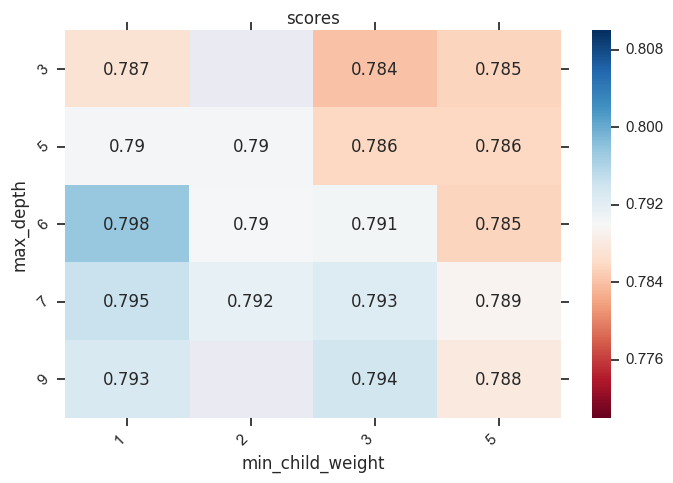

In [81]:
# import re

# paraRes = [ 'dict_values([3, 5])0.7855309218203034', 'dict_values([3, 3])0.7842473745624271', 'dict_values([1, 3])0.7871411901983665', 'dict_values([1, 5])0.7904317386231039']
# for da in paraRes:
#     print(re.findall( r'\[(.+)\]', da))
#     print(re.findall( r'(\d{5,20})', da)[0][:4])



import numpy as np; np.random.seed(0)
import seaborn as sns; 
sns.set()

# flights = sns.load_dataset("flights")
# flights = flights.pivot("max_depth", "min_child_weight", "scores")
flights = data.pivot("max_depth", "min_child_weight", "scores")
# ax = sns.heatmap(flights, cmap="YlGnBu")



f, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(flights,cmap = 'RdBu',ax=ax,vmin=0.77, vmax=0.81,annot=True,fmt ='0.3g')

#设置坐标字体方向
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=45, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')
plt.xlabel('min_child_weight')#设置坐标名称
plt.ylabel('max_depth')
plt.title('scores')#标题
plt.show()




# Plot out seaching result of subSample| subTreeSample

# 树的深度不高，暂时不用调  Plot just gamma no serach  =》 range 0，+

[(1, 0), (2, 0.01), (3, 0.03), (4, 0.1), (5, 0.3), (6, 1), (7, 3), (8, 7)]


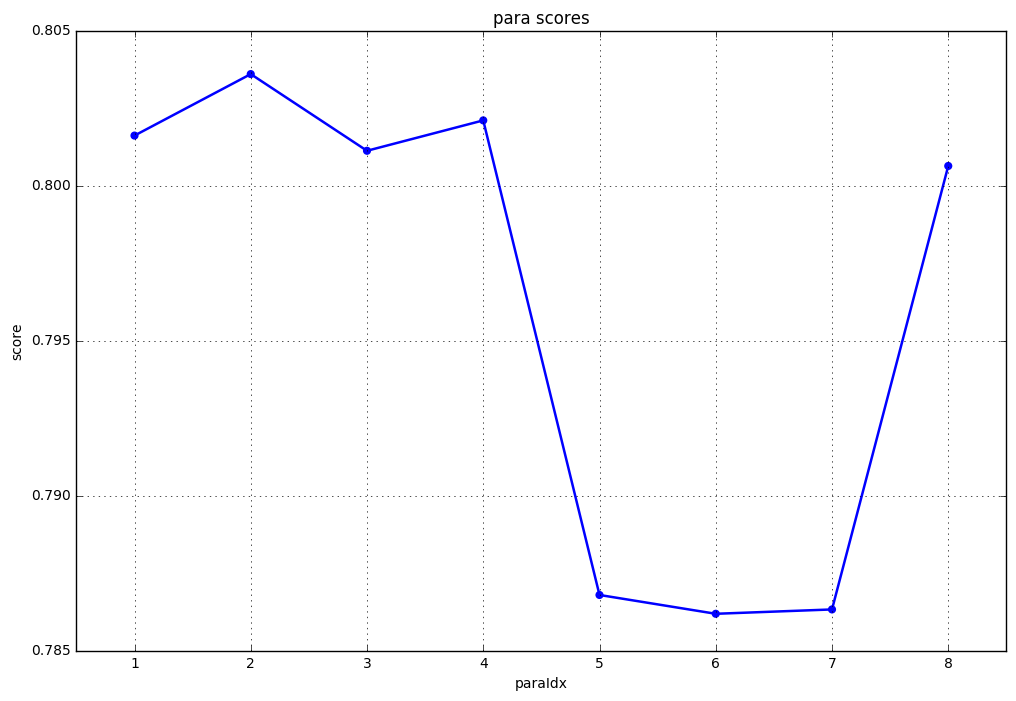

In [19]:
import os
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
import pandas as pd
%matplotlib inline

# [0, 0.001,0.003,0.01,0.03, 0.05,\ 0.1,0.3,0.5 
prsc = [
    
    
    
    
    
    
    [0, 0.8016102683780629], 
    [0.01, 0.8035939323220537],
    [0.03, 0.8011201866977831],
    [0.1, 0.802100350058343],
    [0.3, 0.7867911318553092],
    [1, 0.7861843640606768],
    [3, 0.7863243873978996],
    [7, 0.800630105017503]
]



# prinxAndScore = []
idx = []
score = []
paraIDX = []
for i,v in enumerate(prsc):
    idx.append(i+1)
    score.append(v[1])
    paraIDX.append((i+1, v[0] ))
print(paraIDX)
data = pd.DataFrame()
data["paraIdx"] = idx
data["score"] = score
plt.rcParams["figure.figsize"] = (12,8)
sns.pointplot(x="paraIdx", y="score", data=data)
plt.title("para scores")
plt.grid(True)
